In [2]:
import numpy as np 

def generate_data():
    np.random.seed(42)
    x = np.random.uniform(0, 1, 100)
    epsilon = np.random.normal(0, 0.01, 100)
    y = np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x) + epsilon
    
    # Random split (80% train, 20% test)
    indices = np.random.permutation(len(x))
    split_idx = int(0.8 * len(x))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    x_train, y_train = x[train_indices], y[train_indices]
    x_test, y_test = x[test_indices], y[test_indices]
    
    return x_train, y_train, x_test, y_test

    



In [ ]:
def getStump(x, gradient, loss="squared"):
    best_cut = None
    best_score = float('inf')
    final_left_pred = 0
    final_right_pred = 0
    
    for cut in np.linspace(0, 1, 20):
        left = gradient[x <= cut]
        right = gradient[x > cut]
        if len(left) == 0 or len(right) == 0:
            continue
            
        
        if loss == 'squared':
            left_pred = np.mean(left)
            right_pred = np.mean(right)
            score = np.sum((left - left_pred) ** 2) + np.sum((right - right_pred) ** 2)
        elif loss == 'absolute':
            left_pred = np.median(left)
            right_pred = np.median(right)
            score = np.sum(np.abs(left - left_pred)) + np.sum(np.abs(right - right_pred))
        else:
            left_pred = np.mean(left)
            right_pred = np.mean(right)
            score = np.sum((left - left_pred) ** 2) + np.sum((right - right_pred) ** 2)
            
        if score < best_score:
            best_score = score
            best_cut = cut
            final_left_pred = left_pred
            final_right_pred = right_pred
            
    return best_cut, final_left_pred, final_right_pred


In [4]:

def predict_stump(x, cut, left_pred, right_pred):
    return np.where(x <= cut, left_pred, right_pred)

In [5]:
def predict_stump(x, cut, left_pred, right_pred):
    return np.where(x <= cut, left_pred, right_pred)

def gradient_boosting(x_train, y_train, x_test, y_test, loss="squared", learning=0.01, T=100):
    
    y_train_pred = np.zeros_like(y_train)
    y_test_pred = np.zeros_like(y_test)
    train_loss = []
    stumps = []
    
    
    train_preds_history = [np.copy(y_train_pred)]
    test_preds_history = [np.copy(y_test_pred)]
    
    for t in range(T):
        # Calculate negative gradients
        if loss == 'squared':
            gradient = y_train - y_train_pred
        elif loss == 'absolute':
            gradient = np.sign(y_train - y_train_pred)
            
        # Fit stump to the gradient
        cut, left_pred, right_pred = getStump(x_train, gradient, loss)
        stumps.append((cut, left_pred, right_pred))
        
        # Make predictions with this stump
        pred_train = predict_stump(x_train, cut, left_pred, right_pred)
        pred_test = predict_stump(x_test, cut, left_pred, right_pred)
        
        
        y_train_pred += learning * pred_train
        y_test_pred += learning * pred_test
        
        
        train_preds_history.append(np.copy(y_train_pred))
        test_preds_history.append(np.copy(y_test_pred))
        
        current_loss = 0
        if loss == 'squared':
            current_loss = np.mean((y_train - y_train_pred) ** 2)
        elif loss == 'absolute':
            current_loss = np.mean(np.abs(y_train - y_train_pred))
        train_loss.append(current_loss)
    
    return y_train_pred, y_test_pred, train_loss, stumps, train_preds_history, test_preds_history


In [6]:
x_train, y_train, x_test, y_test = generate_data()

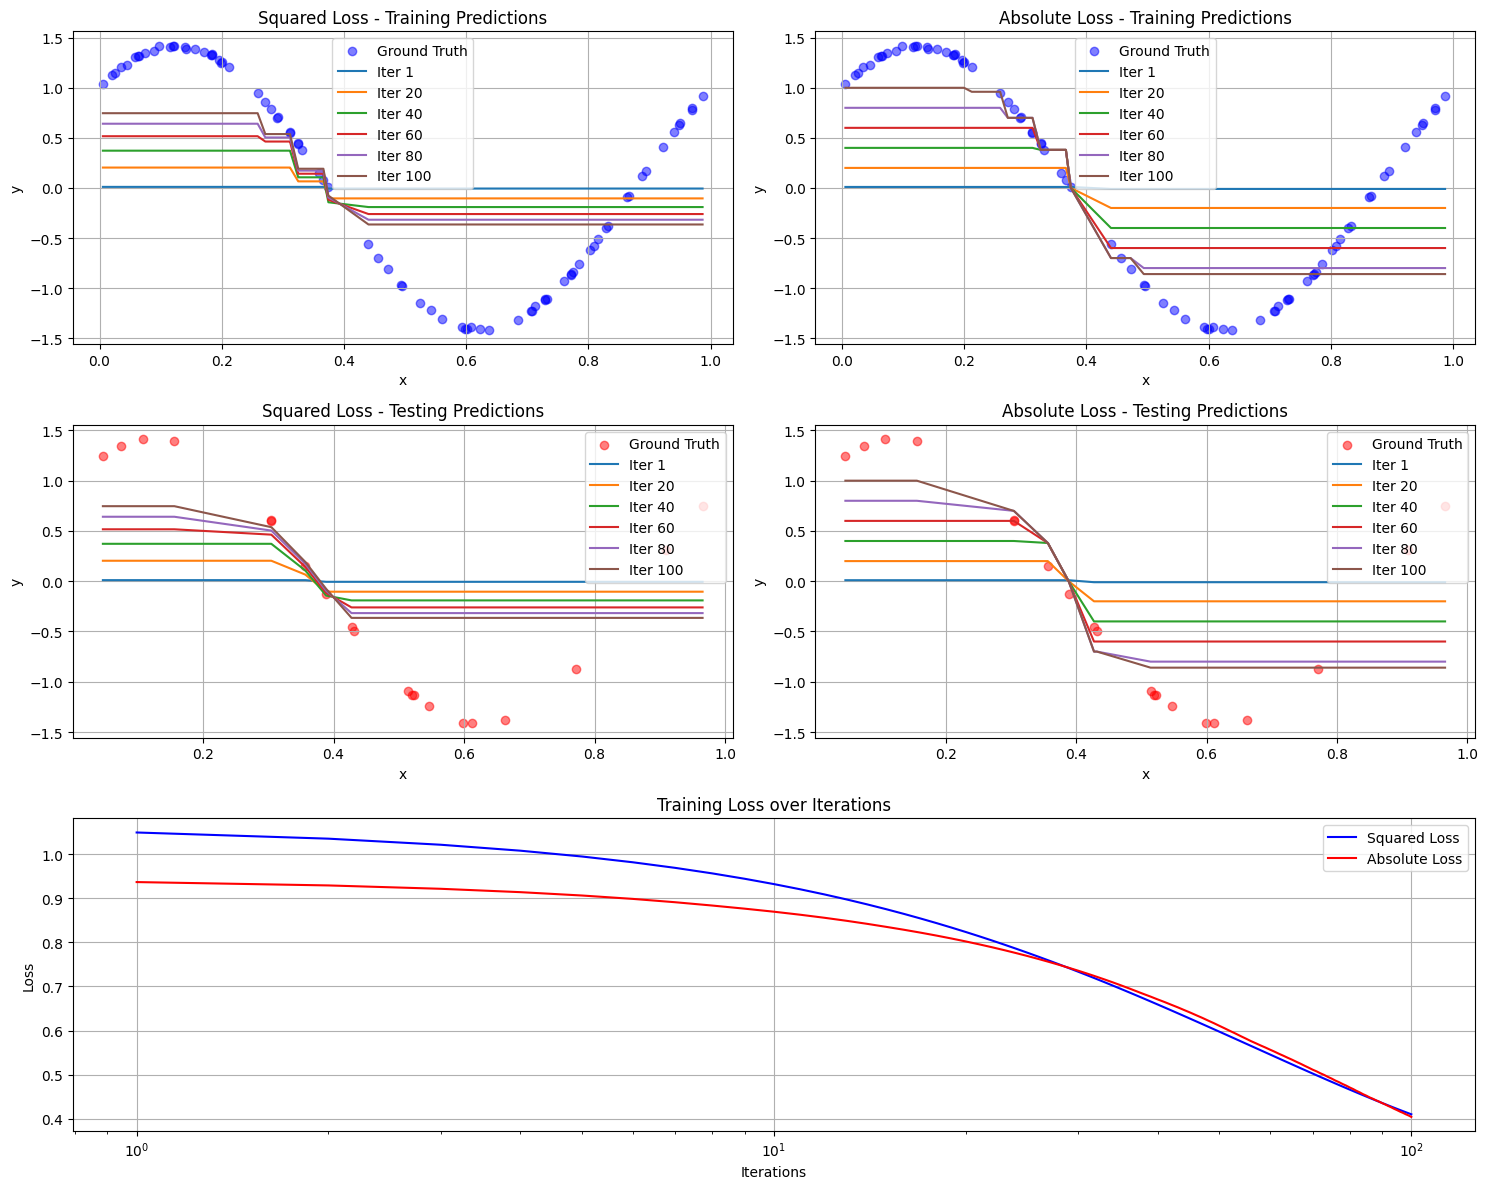

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


iterations_to_plot = [1, 20, 40, 60, 80, 100]

# Run gradient boosting with both loss functions
results = {}
for loss_type in ['squared', 'absolute']:
    y_train_pred, y_test_pred, train_loss, stumps, train_preds_history, test_preds_history = gradient_boosting(
        x_train, y_train, x_test, y_test, loss=loss_type, learning=0.01, T=100)
    
    results[loss_type] = {
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_loss': train_loss,
        'stumps': stumps,
        'train_preds_history': train_preds_history,
        'test_preds_history': test_preds_history
    }


fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 2)


for i, loss_type in enumerate(['squared', 'absolute']):
    
    train_preds_history = results[loss_type]['train_preds_history']
    test_preds_history = results[loss_type]['test_preds_history']
    train_loss = results[loss_type]['train_loss']
    
    
    ax1 = fig.add_subplot(gs[0, i])
    
    sorted_idx = np.argsort(x_train)
    x_sorted = x_train[sorted_idx]
    y_sorted = y_train[sorted_idx]
    
    
    ax1.scatter(x_train, y_train, color='blue', alpha=0.5, label='Ground Truth')
    
    
    for iter_idx, iter_num in enumerate(iterations_to_plot):
        if iter_num < len(train_preds_history):
            preds = train_preds_history[iter_num]
           
            preds_sorted = preds[sorted_idx]
            ax1.plot(x_sorted, preds_sorted, label=f'Iter {iter_num}')
    
    ax1.set_title(f'{loss_type.capitalize()} Loss - Training Predictions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.grid(True)
    ax1.legend()
    
    
    ax2 = fig.add_subplot(gs[1, i])
   
    sorted_idx_test = np.argsort(x_test)
    x_test_sorted = x_test[sorted_idx_test]
    y_test_sorted = y_test[sorted_idx_test]
    
  
    ax2.scatter(x_test, y_test, color='red', alpha=0.5, label='Ground Truth')
    
   
    for iter_idx, iter_num in enumerate(iterations_to_plot):
        if iter_num < len(test_preds_history):
            preds = test_preds_history[iter_num]
            
            preds_sorted = preds[sorted_idx_test]
            ax2.plot(x_test_sorted, preds_sorted, label=f'Iter {iter_num}')
    
    ax2.set_title(f'{loss_type.capitalize()} Loss - Testing Predictions')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.grid(True)
    ax2.legend()

ax3 = fig.add_subplot(gs[2, :])
iterations = np.arange(1, len(results['squared']['train_loss']) + 1)
ax3.plot(iterations, results['squared']['train_loss'], 'b-', label='Squared Loss')
ax3.plot(iterations, results['absolute']['train_loss'], 'r-', label='Absolute Loss')
ax3.set_title('Training Loss over Iterations')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Loss')
ax3.set_xscale('log')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()